<a href="https://colab.research.google.com/github/papapatcharakit/telecom-thai-qa-reader-model/blob/main/reader_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is adapted from HuggingFace example on QA for WangchanBERTa. Some processing functions and metrics are modified to suit Thai language.


## Installs and Imports

In [ ]:
!pip install torch==1.4.0.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.4.0. (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.4.0.


In [ ]:
!pip install -Uqq datasets pythainlp==2.2.4 transformers==4.4.0 tensorflow==2.4.0 tensorflow_text emoji seqeval sentencepiece fuzzywuzzy

!npx degit --force https://github.com/vistec-AI/thai2transformers#dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0rc0, 2.12.0rc1)
ERROR: No matching distribution found for tensorflow==2.4.0
npx: installed 1 in 2.382s
> destination directory is not empty. Using --force, continuing
> cloned vistec-AI/thai2transformers#dev


In [ ]:
pip install optuna 

In [ ]:
%load_ext autoreload
%autoreload 2

import pythainlp, transformers
pythainlp.__version__, transformers.__version__ #fix pythainlp to stabilize word tokenization for metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('3.1.1', '4.26.1')

In [ ]:
import collections
import logging
import pprint
import re
from tqdm.auto import tqdm

import numpy as np
import torch

#datasets
from datasets import (
    load_dataset, 
    load_metric, 
    concatenate_datasets,
    load_from_disk,
)

#transformers
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
)

#thai2transformers
import thai2transformers
from thai2transformers.metrics import (
    squad_newmm_metric,
    question_answering_metrics,
)
from thai2transformers.preprocess import (
    prepare_qa_train_features
)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer,
    SEFR_SPLIT_TOKEN
)

from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords


## Choose Pretrained Models

In [ ]:
model_names = [
    'wangchanberta-base-att-spm-uncased',
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'wangchanberta-base-wiki-newmm',
    'wangchanberta-base-wiki-ssg',
    'wangchanberta-base-wiki-sefr',
    'wangchanberta-base-wiki-spm',
]

tokenizers = {
    'wangchanberta-base-att-spm-uncased': AutoTokenizer,
    'xlm-roberta-base': AutoTokenizer,
    'bert-base-multilingual-cased': AutoTokenizer,
    'wangchanberta-base-wiki-newmm': ThaiWordsNewmmTokenizer,
    'wangchanberta-base-wiki-ssg': ThaiWordsSyllableTokenizer,
    'wangchanberta-base-wiki-sefr': FakeSefrCutTokenizer,
    'wangchanberta-base-wiki-spm': ThaiRobertaTokenizer,
    
}
public_models = ['xlm-roberta-base', 'bert-base-multilingual-cased'] 
#@title Choose Pretrained Model
model_name = "wangchanberta-base-att-spm-uncased" #@param ["wangchanberta-base-att-spm-uncased", "xlm-roberta-base", "bert-base-multilingual-cased", "wangchanberta-base-wiki-newmm", "wangchanberta-base-wiki-syllable", "wangchanberta-base-wiki-sefr", "wangchanberta-base-wiki-spm"]

#create tokenizer
tokenizer = tokenizers[model_name].from_pretrained(
                f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
                revision='main',
                model_max_length=416,)

## Load datasets

In [ ]:
# test 1 เสร็จแล้วลบออก
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.0 MB/s eta 0:00:00


In [ ]:
# test 2 เสร็จแล้วลบออก

#datasets
from datasets import (
    load_dataset, 
    load_metric, 
    concatenate_datasets,
    load_from_disk,
)

In [ ]:
# test 2 เสร็จแล้วลบออก

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# test 3 เสร็จแล้วลบออก

%cd /content/drive/MyDrive

datasets = load_dataset("json", data_files={"newDataset_2_for_db.json"})

# datasets = load_dataset("iapp_wiki_qa_squad") #test on other datasets
datasets

/content/drive/MyDrive


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8a2dc76a05738c2f/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question_id', 'article_id', 'context', 'question', 'answers'],
        num_rows: 302
    })
})

In [ ]:
# test 4 เสร็จแล้วลบออก
import json, io

all_context = datasets['train']['context']

json_context = json.dumps(all_context, ensure_ascii=False)
# json_context

with open("all_context.json", "w", encoding="utf-8") as outfile:
  outfile.write(json_context)

# with io.open('all_context_from_train_dataset.json', 'w', encoding='utf-8') as f:
#   f.write(json)


In [ ]:
# test 5 เสร็จแล้วลบออก

len(all_context)
all_context

['ชื่อหลักสูตรภาษาไทย คือ หลักสูตรวิศวกรรมศาสตร์บัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย และชื่อหลักสูตรภาษาอังกฤษ คือ Bachelor of Engineering in Telecommunications and Network Engineering',
 'ชื่อหลักสูตรภาษาไทย คือ หลักสูตรวิศวกรรมศาสตร์บัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย และชื่อหลักสูตรภาษาอังกฤษ คือ Bachelor of Engineering in Telecommunications and Network Engineering',
 'ชื่อปริญญาและสาขาวิชา ชื่อเต็ม (ไทย) : วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อย่อ (ไทย) : วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อเต็ม (อังกฤษ) : Bachelor of Engineering (Telecommunications and Network Engineering) ชื่อย่อ (อังกฤษ) : B.Eng. (Telecommunications and Network Engineering)',
 'ชื่อปริญญาและสาขาวิชา ชื่อเต็ม (ไทย) : วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อย่อ (ไทย) : วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อเต็ม (อังกฤษ) : Bachelor of Engineering (Telecommunications and Network Engineering) ชื่อย่อ (อังกฤษ) : B.Eng. (Telecommunications and Network Engineering)'

In [ ]:
# test 6 เสร็จแล้วลบออก

# the given list contains duplicates
mylist = all_context # the original list of contexts with duplicates

newlist = [] # empty list to hold unique elements from the list
duplist = [] # empty list to hold the duplicate elements from the list
for i in mylist:
    if i not in newlist:
        newlist.append(i)
    else:
        duplist.append(i) # this method catches the first duplicate entries, and appends them to the list

# print the duplicate entries, and the unique entries
# print("List of duplicates", duplist)
# print("Unique Item List", newlist) # prints the final list of unique items

len(newlist)
newlist

['ชื่อหลักสูตรภาษาไทย คือ หลักสูตรวิศวกรรมศาสตร์บัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย และชื่อหลักสูตรภาษาอังกฤษ คือ Bachelor of Engineering in Telecommunications and Network Engineering',
 'ชื่อปริญญาและสาขาวิชา ชื่อเต็ม (ไทย) : วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อย่อ (ไทย) : วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อเต็ม (อังกฤษ) : Bachelor of Engineering (Telecommunications and Network Engineering) ชื่อย่อ (อังกฤษ) : B.Eng. (Telecommunications and Network Engineering)',
 'วิชาเอกหรือความเชี่ยวชาญเฉพาะของหลักสูตร เป็นหลักสูตรที่มุ่งให้บัณฑิตมีความเชี่ยวชาญทั้งภาคทฤษฎีและปฏิบัติในกลุ่มวิชาเฉพาะสาขาวิศวกรรมโทรคมนาคมและโครงข่าย ทั้งในเชิงลึกและเชิงกว้าง สามารถนำองค์ความรู้ทางด้านเครือข่ายโทรคมนาคมการประมวลผลสัญญาณสำหรับการสื่อสาร การออกแบบวงจรอิเล็กทรอนิกส์สำหรับการสื่อสาร และระบบสื่อสารไร้สาย มาบูรณาการปรับใช้ได้อย่างมีประสิทธิภาพ ',
 'จำนวนหน่วยกิตที่เรียนตลอดหลักสูตร ไม่น้อยกว่า 146 หน่วยกิต',
 'รูปแบบของหลักสูตรเป็นหลักสูตรปริญญาตรี 4 ปี',
 'ประเภทหลักสูตรเป็น

In [ ]:
# test 7 เสร็จแล้วลบออก

for i in newlist[:]:
  db_insert_format = '(' + "'" + i + "'" + ')'
  print(db_insert_format+",")


('ชื่อหลักสูตรภาษาไทย คือ หลักสูตรวิศวกรรมศาสตร์บัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย และชื่อหลักสูตรภาษาอังกฤษ คือ Bachelor of Engineering in Telecommunications and Network Engineering'),
('ชื่อปริญญาและสาขาวิชา ชื่อเต็ม (ไทย) : วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อย่อ (ไทย) : วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อเต็ม (อังกฤษ) : Bachelor of Engineering (Telecommunications and Network Engineering) ชื่อย่อ (อังกฤษ) : B.Eng. (Telecommunications and Network Engineering)'),
('วิชาเอกหรือความเชี่ยวชาญเฉพาะของหลักสูตร เป็นหลักสูตรที่มุ่งให้บัณฑิตมีความเชี่ยวชาญทั้งภาคทฤษฎีและปฏิบัติในกลุ่มวิชาเฉพาะสาขาวิศวกรรมโทรคมนาคมและโครงข่าย ทั้งในเชิงลึกและเชิงกว้าง สามารถนำองค์ความรู้ทางด้านเครือข่ายโทรคมนาคมการประมวลผลสัญญาณสำหรับการสื่อสาร การออกแบบวงจรอิเล็กทรอนิกส์สำหรับการสื่อสาร และระบบสื่อสารไร้สาย มาบูรณาการปรับใช้ได้อย่างมีประสิทธิภาพ '),
('จำนวนหน่วยกิตที่เรียนตลอดหลักสูตร ไม่น้อยกว่า 146 หน่วยกิต'),
('รูปแบบของหลักสูตรเป็นหลักสูตรปริญญาตรี 4 ปี'),
('ประเภทหลักสูต

In [ ]:
#parameterizing columns
CONTEXT_COL = 'context'
QUESTION_COL = 'question'
ANSWERS_COL = 'answers'
TEXT_COL = 'text'
START_COL = 'answer_start'
# END_COL = 'answer_end'
QUESTION_ID_COL = 'question_id'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# datasets = load_from_disk('iapp_thaiqa')

%cd /content/drive/MyDrive

datasets = load_dataset("json", data_files={"train":"newDataset.json", "validation": "newDataset_validation.json", "test": "newDataset_test.json"})

# datasets = load_dataset("iapp_wiki_qa_squad") #test on other datasets
datasets

/content/drive/MyDrive


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-e722277d23f0d28c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question_id', 'article_id', 'context', 'question', 'answers'],
        num_rows: 302
    })
    validation: Dataset({
        features: ['question_id', 'article_id', 'context', 'question', 'answers'],
        num_rows: 55
    })
    test: Dataset({
        features: ['question_id', 'article_id', 'context', 'question', 'answers'],
        num_rows: 21
    })
})

In [ ]:
datasets['train'][0]

{'question_id': '00000',
 'article_id': '0',
 'context': 'หลักสูตรวิศวกรรมศาสตรบัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย (Bachelor of Engineering in Telecommunications and Network Engineering)',
 'question': 'ชื่อหลักสูตรภาษาไทย',
 'answers': {'answer_end': [64],
  'answer_start': [0],
  'text': ['หลักสูตรวิศวกรรมศาสตรบัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย']}}

In [ ]:
#lowercase when using uncased model
def lowercase_example(example):
    example[QUESTION_COL] =  example[QUESTION_COL].lower()
    example[CONTEXT_COL] =  example[CONTEXT_COL].lower()
    example[ANSWERS_COL][TEXT_COL] =  [example[ANSWERS_COL][TEXT_COL][0].lower()]
    return example

if model_name == 'wangchanberta-base-att-spm-uncased':
    datasets = datasets.map(lowercase_example)

  0%|          | 0/302 [00:00<?, ?ex/s]

  0%|          | 0/55 [00:00<?, ?ex/s]

  0%|          | 0/21 [00:00<?, ?ex/s]

##Text Augment Task

In [ ]:
!pip install thaitextaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from thaitextaug.wordnet import WordNetAug
from thaitextaug.word2vec import Thai2fitAug
from thaitextaug.word2vec import BPEmbAug

## Preprocessing the training data

In [ ]:
def _get_context_span(input_ids,
                     sequence_ids,
                     answers, 
                     start_col, 
                     text_col='text',
                     pad_on_right=True):
    
    # Start/end character index of the answer in the text.
    start_char = answers[start_col][0] 
    end_char = start_char + len(answers[text_col][0]) + 1

    # Start token index of the current span in the text.
    token_start_index = 0
    while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
        token_start_index += 1

    # End token index of the current span in the text.
    token_end_index = len(input_ids) - 1
    while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
        token_end_index -= 1
    
    return token_start_index, token_end_index, start_char, end_char

def _get_answer_span(tokenized_examples,
                    offsets,
                    start_char,
                    end_char,
                    token_start_index,
                    token_end_index,):

    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1

    return start_position, end_position

def prepare_qa_train_features(examples, 
                           tokenizer,
                           question_col='question',
                           context_col='context',
                           answers_col='answers',
                           start_col='answer_start',
                           text_col='text',
                           pad_on_right=True,
                           max_length=416,
                           doc_stride=128):
    
    tokenized_examples = tokenizer(
        examples[question_col],
        examples[context_col],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride, #overlapping of overflowing tokens
        return_overflowing_tokens=True, #return multiple input ids if exceeding max_length
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping") #map overflowing examples to original examples
    offset_mapping = tokenized_examples.pop("offset_mapping") #offset map; character index not resetted across overflowing examples

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    #loop through all examples' offset_mapping
    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i] #a list of tokens
        cls_index = input_ids.index(tokenizer.cls_token_id) #use cls as answer when there is no answer 
        sequence_ids = tokenized_examples.sequence_ids(i) #sequence_ids 0 for question and 1 for context
        sample_index = sample_mapping[i] #since many examples can point to the same question due to overflowing
        answers = examples[answers_col][sample_index] #answers of each example

        # If no answers are given, set the cls_index as answer
        if len(answers[text_col]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            token_start_index, token_end_index, start_char, end_char = _get_context_span(input_ids=input_ids,
                                                                sequence_ids=sequence_ids,
                                                                answers=answers, 
                                                                start_col=start_col, 
                                                                text_col=text_col,
                                                                pad_on_right=pad_on_right)
            # If answer is not in span, return cls_index as answer
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char-1):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:                
                start_position, end_position = _get_answer_span(tokenized_examples,
                    offsets,
                    start_char,
                    end_char,
                    token_start_index,
                    token_end_index,)
                tokenized_examples["start_positions"].append(start_position)
                tokenized_examples["end_positions"].append(end_position)
                
    return tokenized_examples

In [ ]:
#using function in notebook
tokenized_datasets = datasets.map(lambda x: prepare_qa_train_features(x, tokenizer), 
                                  batched=True, 
                                  remove_columns=datasets["train"].column_names)
tokenized_datasets

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 375
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 55
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 21
    })
})

###Test

In [ ]:
print(tokenized_datasets['train']['start_positions'])
print(tokenized_datasets['train']['end_positions'])

[7, 18, 27, 44, 63, 98, 21, 22, 12, 13, 23, 16, 14, 17, 16, 38, 74, 13, 13, 21, 17, 35, 45, 90, 106, 158, 46, 50, 36, 19, 120, 21, 0, 0, 229, 0, 0, 33, 59, 64, 57, 18, 31, 30, 41, 41, 41, 74, 42, 91, 16, 23, 35, 41, 48, 58, 69, 78, 78, 87, 79, 18, 37, 50, 73, 73, 81, 87, 74, 236, 74, 236, 72, 234, 34, 0, 39, 0, 168, 0, 192, 0, 246, 0, 273, 0, 299, 41, 335, 82, 370, 119, 395, 140, 0, 169, 0, 219, 0, 252, 0, 296, 0, 328, 0, 359, 41, 0, 46, 0, 165, 0, 0, 188, 0, 0, 205, 0, 0, 244, 0, 0, 266, 0, 0, 294, 37, 0, 331, 79, 0, 369, 120, 0, 398, 146, 0, 0, 202, 0, 0, 233, 0, 0, 273, 0, 0, 311, 65, 0, 390, 127, 0, 0, 168, 0, 373, 135, 0, 0, 181, 44, 49, 32, 47, 70, 124, 156, 26, 33, 127, 0, 144, 0, 174, 0, 221, 0, 260, 0, 284, 0, 316, 57, 381, 139, 389, 127, 0, 154, 24, 39, 64, 66, 73, 61, 174, 179, 60, 28, 43, 110, 112, 93, 214, 32, 47, 66, 77, 27, 40, 45, 25, 105, 121, 150, 150, 12, 36, 61, 70, 101, 31, 37, 62, 32, 39, 60, 77, 96, 110, 22, 46, 338, 122, 150, 189, 206, 243, 266, 293, 310, 348, 2

In [ ]:
inputs = tokenizer(
    datasets["train"][:]["question"],
    datasets["train"][:]["context"],
    max_length=416,
    truncation="only_second",
    stride=128,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

In [ ]:
answers = datasets["train"][:]["answers"]

for idx in range(len(inputs['input_ids'])):

  sample_idx = inputs["overflow_to_sample_mapping"][idx]
  answer = answers[sample_idx]["text"][0]
  
  start = tokenized_datasets['train']['start_positions'][idx] 
  end = tokenized_datasets['train']['end_positions'][idx]
  labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end])

  print("idx : ", idx)
  print("Here is where each comes from : ", inputs["overflow_to_sample_mapping"][idx])
  print(f"Theoretical answer: {answer},\nlabels give: {labeled_answer} \n\n")

  # if(answer != labeled_answer and labeled_answer==0):
  #   print(inputs["overflow_to_sample_mapping"][idx])



idx :  0
Here is where each comes from :  0
Theoretical answer: หลักสูตรวิศวกรรมศาสตรบัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย,
labels give: หลักสูตรวิศวกรรมศาสตรบัณฑิต สาขาวิชาวิศวกรรมโทรคมนาคมและโครงข่าย 


idx :  1
Here is where each comes from :  1
Theoretical answer: bachelor of engineering in telecommunications and network engineering,
labels give: bachelor of engineering in telecommunications and network engineering 


idx :  2
Here is where each comes from :  2
Theoretical answer: วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย),
labels give: วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) 


idx :  3
Here is where each comes from :  3
Theoretical answer: วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย),
labels give: วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย) 


idx :  4
Here is where each comes from :  4
Theoretical answer: bachelor of engineering (telecommunications and network engineering),
labels give: bachelor of engineering (telecommunications and network engineering) 


idx :  5
He

## Finetuning the model

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(
            f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
            revision='main',)

Downloading:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForQuestionAnswering were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['qa_outputs.weight'

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 13.0 MB/s 
     |████████████████████████████████| 168 kB 66.9 MB/s 
     |████████████████████████████████| 182 kB 80.1 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 168 kB 80.9 MB/s 
     |████████████████████████████████| 166 kB 79.5 MB/s 
     |████████████████████████████████| 166 kB 82.0 MB/s 
     |████████████████████████████████| 162 kB 80.4 MB/s 
     |████████████████████████████████| 162 kB 64.3 MB/s 
     |████████████████████████████████| 158 kB 64.2 MB/s 
     |████████████████████████████████| 157 kB 76.3 MB/s 
     |████████████████████████████████| 157 kB 79.4 MB/s 
     |████████████████████████████████| 157 kB 55.6 MB/s 
     |████████████████████████████████| 157 kB 72.9 MB/s 
     |████████████████████████████████| 157 kB 81.3 MB/s 
     |███████████████████████████

In [ ]:
wandb login

In [ ]:
import wandb
from transformers import TrainingArguments, Trainer

wandb.init(project="my-test-project")

learning_rate = 8e-05

args = TrainingArguments(
    f"finetune_telecom_thaiqa",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.0001,
    # save_steps=2000,
    fp16=True,
    logging_steps=20,
    report_to="wandb",
)

data_collator = default_data_collator

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

AttributeError: ignored

In [ ]:
wandb.finish()

eval/loss,▁██
eval/runtime,▁▃█
eval/samples_per_second,█▆▁
train/epoch,▁▂▄▅▆█
train/learning_rate,█▅▁
train/loss,█▂▁
train/total_flos,▁
train/train_runtime,▁
train/train_samples_per_second,▁
eval/loss,11.18672
eval/runtime,1.2248


In [ ]:
learning_rate = 8e-05

args = TrainingArguments(
    f"finetune_telecom_thaiqa",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.0001,
    # save_steps=2000,
    fp16=True,
    logging_steps=20,
    report_to="none"
)

# report_to="wandb",


Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [ ]:
data_collator = default_data_collator

We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training).

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

We can now finetune our model by just calling the `train` method:

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,4.263100,9.753967,1.227300,44.814000
2,3.314700,11.230285,1.233000,44.606000
3,2.876900,11.685781,1.250800,43.971000


TrainOutput(global_step=72, training_loss=3.362974908616808, metrics={'train_runtime': 39.5978, 'train_samples_per_second': 1.818, 'total_flos': 293872256496000.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 85551, 'init_mem_gpu_alloc_delta': 419929600, 'init_mem_cpu_peaked_delta': 56338, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 419976, 'train_mem_gpu_alloc_delta': 1293657088, 'train_mem_cpu_peaked_delta': 389650, 'train_mem_gpu_peaked_delta': 5791016960})

In [ ]:
wandb.finish()/content/drive/MyDrive/finetune_telecom_thaiqa_1215

Since this training is particularly long, let's save the model just in case we need to restart.

In [ ]:
trainer.save_model("finetune_telecom_thaiqa_1215")

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#load finetuned model
model = AutoModelForQuestionAnswering.from_pretrained('BestQAModel')

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

NameError: ignored

##Hyperparameter Optimization

In [ ]:

#----------------------------------------------------------------------------------------------------
#  Optuna tunuing                          
#----------------------------------------------------------------------------------------------------

import datasets 
import optuna 
from datasets import load_dataset 
import os.path
from os import path

def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

#Object Parameters
LR_MIN = 4e-5
LR_CEIL = 0.01
WD_MIN = 4e-5
WD_CEIL = 0.01
MIN_EPOCHS = 2
MAX_EPOCHS = 5
PER_DEVICE_EVAL_BATCH = 16
PER_DEVICE_TRAIN_BATCH = 16
NUM_TRIALS = 20
SAVE_DIR = 'opt-test'
NAME_OF_MODEL = 'finetune_telecom_thaiqa'
MAX_LENGTH = 416

# Import datasets and partition
# Replace this part with our dataset and preprocess routines
# print_custom('Loading in datasets')
# dataset: datasets.DatasetDict = load_dataset("ade_corpus_v2", "Ade_corpus_v2_classification")  
# dataset = dataset['train'].train_test_split(0.2)  

# Load in Electra small
# print_custom('Initializing Electra Small pretrained tokenizer')
# model_name = "google/electra-small-discriminator"  
# tokenizer = AutoTokenizer.from_pretrained(model_name)  
# model = AutoModelForSequenceClassification.from_pretrained(model_name)      

# Preprocessing functions
# print_custom('Preprocessing text...')
# def preprocess(examples):     
#   return tokenizer(
#       examples['question'],
#       examples['context'],
#       truncation="only_second",
#       max_length=MAX_LENGTH,
#       stride=doc_stride, #overlapping of overflowing tokens
#       return_overflowing_tokens=True, #return multiple input ids if exceeding max_length
#       return_offsets_mapping=True,
#       padding="max_length",)

# dataset = dataset.map(preprocess, batched=True)   

#----------------------------------------------------------------------------------------------------
# Optuna setup
#----------------------------------------------------------------------------------------------------
print_custom('Setting up Optuna study')

def objective(trial: optuna.Trial):     
    # model = AutoModelForSequenceClassification.from_pretrained(model_name)      
    training_args = TrainingArguments(         
        output_dir=SAVE_DIR, 
        learning_rate=trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),         
        weight_decay=trial.suggest_loguniform('weight_decay', WD_MIN, WD_CEIL),         
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),         
        per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH,         
        per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,         
        disable_tqdm=True)     

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],)  
        
    
    result = trainer.train()     
    return result.training_loss

#----------------------------------------------------------------------------------------------------
#                    CREATE OPTUNA STUDY
#----------------------------------------------------------------------------------------------------

print_custom('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-electra', direction='minimize') 
study.optimize(func=objective, n_trials=NUM_TRIALS)  

# This can be used to train the final model. Passed through using kwargs into the model
print_custom('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch = int(study.best_params['num_train_epochs'])

print_custom('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')

print_custom('Create dictionary of the best hyperparameters')
best_hp_dict = {
    'best_learning_rate' : best_lr,
    'best_weight_decay': best_weight_decay,
    'best_epoch': best_epoch
}


#----------------------------------------------------------------------------------------------------
#                   TRAIN BASED ON OPTUNAS SELECTED HP
#----------------------------------------------------------------------------------------------------
 
print_custom('Training the model on the custom parameters')

training_args = TrainingArguments(         
    output_dir=SAVE_DIR, 
    learning_rate=best_lr,         
    weight_decay=best_weight_decay,         
    num_train_epochs=best_epoch,         
    per_device_train_batch_size=8,         
    per_device_eval_batch_size=8,         
    disable_tqdm=True)     

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],)      
    
result = trainer.train() 
trainer.evaluate()

print_custom('Saving the best Optuna tuned model')
if not path.exists('model'):
    os.mkdir('model')

model_path = "model/{}".format(NAME_OF_MODEL)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

[I 2022-12-12 08:06:44,531] A new study created in memory with name: hp-search-electra




Setting up Optuna study
----------------------------------------------------------------------------------------------------


Triggering Optuna study
----------------------------------------------------------------------------------------------------


<ipython-input-65-47d77c23e93b>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate=trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
<ipython-input-65-47d77c23e93b>:67: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay=trial.suggest_loguniform('weight_decay', WD_MIN, WD_CEIL),


{'train_runtime': 114.7914, 'train_samples_per_second': 0.871, 'epoch': 2.0}


[I 2022-12-12 08:08:42,976] Trial 0 finished with value: 6.067391967773437 and parameters: {'learning_rate': 0.0010958612199352255, 'weight_decay': 0.00030927441690580736, 'num_train_epochs': 2}. Best is trial 0 with value: 6.067391967773437.


{'train_runtime': 238.6841, 'train_samples_per_second': 0.838, 'epoch': 4.0}


[I 2022-12-12 08:12:45,209] Trial 1 finished with value: 6.01399658203125 and parameters: {'learning_rate': 0.00037323313401426035, 'weight_decay': 0.0001291940426203743, 'num_train_epochs': 4}. Best is trial 1 with value: 6.01399658203125.


{'train_runtime': 183.97, 'train_samples_per_second': 0.815, 'epoch': 3.0}


[I 2022-12-12 08:15:52,753] Trial 2 finished with value: 5.962919108072916 and parameters: {'learning_rate': 0.00018393587413906333, 'weight_decay': 0.004863317811798125, 'num_train_epochs': 3}. Best is trial 2 with value: 5.962919108072916.


{'train_runtime': 183.4923, 'train_samples_per_second': 0.817, 'epoch': 3.0}


[I 2022-12-12 08:18:59,725] Trial 3 finished with value: 5.904711507161458 and parameters: {'learning_rate': 0.0006401585036977217, 'weight_decay': 0.0008885892903611226, 'num_train_epochs': 3}. Best is trial 3 with value: 5.904711507161458.


{'train_runtime': 244.5971, 'train_samples_per_second': 0.818, 'epoch': 4.0}


[I 2022-12-12 08:23:07,794] Trial 4 finished with value: 5.795321044921875 and parameters: {'learning_rate': 0.00014505995885223937, 'weight_decay': 0.00011608687103325498, 'num_train_epochs': 4}. Best is trial 4 with value: 5.795321044921875.


{'train_runtime': 244.6819, 'train_samples_per_second': 0.817, 'epoch': 4.0}


[I 2022-12-12 08:27:15,896] Trial 5 finished with value: 5.624056396484375 and parameters: {'learning_rate': 0.00027557204958656475, 'weight_decay': 0.0012799559008062112, 'num_train_epochs': 4}. Best is trial 5 with value: 5.624056396484375.


{'train_runtime': 304.9052, 'train_samples_per_second': 0.82, 'epoch': 5.0}


[I 2022-12-12 08:32:24,285] Trial 6 finished with value: 6.01582177734375 and parameters: {'learning_rate': 0.002452849086575554, 'weight_decay': 0.0006094868364991831, 'num_train_epochs': 5}. Best is trial 5 with value: 5.624056396484375.


{'train_runtime': 305.0956, 'train_samples_per_second': 0.819, 'epoch': 5.0}


[I 2022-12-12 08:37:32,790] Trial 7 finished with value: 5.95189697265625 and parameters: {'learning_rate': 0.0007468798266952412, 'weight_decay': 0.007616851662913706, 'num_train_epochs': 5}. Best is trial 5 with value: 5.624056396484375.


{'train_runtime': 243.5389, 'train_samples_per_second': 0.821, 'epoch': 4.0}


[I 2022-12-12 08:41:39,665] Trial 8 finished with value: 5.790760498046875 and parameters: {'learning_rate': 0.0006595703552990438, 'weight_decay': 0.0006347291254918644, 'num_train_epochs': 4}. Best is trial 5 with value: 5.624056396484375.


{'train_runtime': 121.7133, 'train_samples_per_second': 0.822, 'epoch': 2.0}


[I 2022-12-12 08:43:44,745] Trial 9 finished with value: 5.37219970703125 and parameters: {'learning_rate': 0.00010181773897535152, 'weight_decay': 9.703168723521204e-05, 'num_train_epochs': 2}. Best is trial 9 with value: 5.37219970703125.


{'train_runtime': 121.9254, 'train_samples_per_second': 0.82, 'epoch': 2.0}


[I 2022-12-12 08:45:50,041] Trial 10 finished with value: 5.103070068359375 and parameters: {'learning_rate': 4.85335076853822e-05, 'weight_decay': 4.5109454955372066e-05, 'num_train_epochs': 2}. Best is trial 10 with value: 5.103070068359375.
[W 2022-12-12 08:46:50,987] Trial 11 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-65-47d77c23e93b>", line 80, in objective
    result = trainer.train()
  File "/usr/local/lib/python3.8/dist-packages/transformers/trainer.py", line 1053, in train
    tr_loss += self.training_step(model, inputs)
  File "/usr/local/lib/python3.8/dist-packages/transformers/trainer.py", line 1461, in training_step
    loss.backward()
  File "/usr/local/lib/python3.8/dist-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/usr/local/

KeyboardInterrupt: ignored

## Test fine-tuned model on QA-pipeline

In [ ]:
datasets['train'][3]

{'question_id': '00003',
 'article_id': '1',
 'context': 'ชื่อปริญญาและสาขาวิชา ชื่อเต็ม (ไทย) : วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อย่อ (ไทย) : วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อเต็ม (อังกฤษ) : bachelor of engineering (telecommunications and network engineering) ชื่อย่อ (อังกฤษ) : b.eng. (telecommunications and network engineering)',
 'question': 'ชื่อย่อ (ไทย) ของชื่อปริญญาและสาขาวิชาคืออะไร',
 'answers': {'answer_end': [141],
  'answer_start': [106],
  'text': ['วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย)']}}

In [ ]:
#test
from tensorflow.python.framework import device
#เอย
from transformers import pipeline


question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

context = """แผนการศึกษาปีที่ 1 ภาคการศึกษาที่ 2 ประกอบไปด้วย 8 รายวิชา ดังนี้ 01006031 แคลคูลัส 2 (calculus 2) 3 (3-0-6) หน่วยกิต,
01006022 ฟิสิกส์ทั่วไป 2 (general physics 2) 3 (3-0-6) หน่วยกิต,
01006023 ปฏิบัติการฟิสิกส์ทั่วไป 2 (general physics laboratory 2) 1 (0-3-2) หน่วยกิต,
01006010 กลศาสตร์วิศวกรรม (engineering mechanics) 3 (3-0-6) หน่วยกิต,
01006015 เขียนแบบวิศวกรรม (engineering drawing) 3 (2-2-5) หน่วยกิต,
90595002 ภาษาอังกฤษเพื่อการสื่อสาร (english for communication) 3 (3-0-6) หน่วยกิต,
90xxxxxx โรงเรียนสร้างเสน่ห์ (charm school) 2 (1-2-3) หน่วยกิต,
90591002 กีฬาและนันทนาการ (sports and recreational activities) 1 (0-3-2) หน่วยกิต,รวม 19 หน่วยกิต"""

question = "ปีที่ 1 ภาคการศึกษาที่ 2 วิชา 01006031 แคลคูลัส 2 (calculus 2) ต้องเรียนทั้งหมดกี่หน่วยกิต"
question_answerer(question=question, context=context)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/question_answering.py:315: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  fw_args = {k: torch.tensor(v, device=self.device) for (k, v) in fw_args.items()}


{'score': 0.8674158453941345,
 'start': 98,
 'end': 118,
 'answer': ' 3 (3-0-6) หน่วยกิต,'}

In [ ]:
#test
from tensorflow.python.framework import device
#เอย
from transformers import pipeline

question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0, handle_impossible_answer=True)

context = """ชื่อปริญญาและสาขาวิชา ชื่อเต็ม (ไทย) : วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อย่อ (ไทย) : วศ.บ. (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อเต็ม (อังกฤษ) : bachelor of engineering (telecommunications and network engineering) ชื่อย่อ (อังกฤษ) : b.eng. (telecommunications and network engineering)"""
question = "ชื่อย่อ (ไทย) ของชื่อปริญญาและสาขาวิชาคืออะไร"
question_answerer(question=question, context=context)

{'score': 0.07504729181528091,
 'start': 38,
 'end': 97,
 'answer': ' วิศวกรรมศาสตรบัณฑิต (วิศวกรรมโทรคมนาคมและโครงข่าย) ชื่อย่อ'}

In [ ]:
#test
from tensorflow.python.framework import device
#เอย
from transformers import pipeline

question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

context = """แผนการศึกษาปีที่ 1 ภาคการศึกษาที่ 2 ประกอบไปด้วย 8 รายวิชา ดังนี้ 01006031 แคลคูลัส 2 (calculus 2) 3 (3-0-6) หน่วยกิต,
01006022 ฟิสิกส์ทั่วไป 2 (general physics 2) 3 (3-0-6) หน่วยกิต,
01006023 ปฏิบัติการฟิสิกส์ทั่วไป 2 (general physics laboratory 2) 1 (0-3-2) หน่วยกิต,
01006010 กลศาสตร์วิศวกรรม (engineering mechanics) 3 (3-0-6) หน่วยกิต,
01006015 เขียนแบบวิศวกรรม (engineering drawing) 3 (2-2-5) หน่วยกิต,
90595002 ภาษาอังกฤษเพื่อการสื่อสาร (english for communication) 3 (3-0-6) หน่วยกิต,
90xxxxxx โรงเรียนสร้างเสน่ห์ (charm school) 2 (1-2-3) หน่วยกิต,
90591002 กีฬาและนันทนาการ (sports and recreational activities) 1 (0-3-2) หน่วยกิต,รวม 19 หน่วยกิต"""

question = "แคล 2 เรียนกี่หน่วยกิต"
question_answerer(question=question, context=context)

{'score': 0.19158707559108734,
 'start': 98,
 'end': 126,
 'answer': ' 3 (3-0-6) หน่วยกิต,01006022'}

## Evaluation

In [ ]:
def prepare_qa_validation_features(examples, 
                           tokenizer,
                           question_col='question',
                           context_col='context',
                           question_id_col = 'question_id',
                           pad_on_right=True,
                           max_length=416,
                           doc_stride=128):

    tokenized_examples = tokenizer(
        examples[question_col],
        examples[context_col],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["example_id"] = []
    pass

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples[question_id_col][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
def _postprocess_qa_predictions(examples,
                               features, 
                               raw_predictions,
                               tokenizer,
                               n_best_size = 20, 
                               max_answer_length = 30,
                               allow_no_answer=False,
                               question_id_col='question_id'):
    
    #get start_logits and end_logits
    all_start_logits, all_end_logits = raw_predictions

    #get `offset_mapping` and `example_id` back
    features.set_format(type=features.format["type"], columns=list(features.features.keys()))

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples[question_id_col])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        context = example["context"]

        min_null_score = None
        valid_answers = []
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]

            # This is what will allow us to map some the positions in our logits to span of texts in the original context.
            offset_mapping = features[feature_index]["offset_mapping"]

            #debug
            input_ids = features[feature_index]['input_ids'] 

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index-1] is None #end_index is the exclusive upperbound
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index-1][1] #end_index is the exclusive upperbound
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text_decode": tokenizer.decode(input_ids[start_index:end_index]),
                            "text": context[start_char:end_char],
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid failure.
            best_answer = {"text": "", "score": 0.0}
            
        if not allow_no_answer:
            predictions[example[question_id_col]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example[question_id_col]] = answer

    return predictions

In [ ]:
def question_answering_metrics(datasets,
                               trainer,
                               metric=squad_newmm_metric,
                               n_best_size=20,
                               max_answer_length=30,
                               allow_no_answer=False,
                               question_col='question',
                               context_col='context',
                               question_id_col='question_id',
                               answers_col='answers',
                               text_col='text',
                               start_col='answer_start',
                               pad_on_right=True,
                               max_length=416,
                               doc_stride=128):
    
    validation_features = datasets.map(
        lambda examples: prepare_qa_validation_features(examples=datasets, 
                           tokenizer=trainer.tokenizer,
                           question_col=question_col,
                           context_col=context_col,
                           question_id_col = question_id_col,
                           pad_on_right=pad_on_right,
                           max_length=max_length,
                           doc_stride=doc_stride),
        batched=True,
        remove_columns=datasets.column_names
    )
    
    #logits for start and end
    pred = trainer.predict(validation_features)
    
    #question_id, answer text format
    question_id_predictions = _postprocess_qa_predictions(examples=datasets,
                               features=validation_features, 
                               raw_predictions=pred.predictions,
                               tokenizer=trainer.tokenizer,
                               n_best_size = n_best_size, 
                               max_answer_length = max_answer_length,
                               allow_no_answer = allow_no_answer,
                               question_id_col=question_id_col)


    #format to have same field names as squad
    formatted_predictions = [{"id": str(k), "prediction_text": v} for k, v in question_id_predictions.items()]

    #format to have same field names as squad
    references = [{"id": str(ex[question_id_col]), 
                   "answers": {'text': ex[answers_col][text_col],
                               'answer_start':ex[answers_col][start_col]}} for ex in datasets]

    return metric.compute(predictions=formatted_predictions, references=references), formatted_predictions, references

##Run

In [ ]:
#using function in notebook
metrics, formatted_predictions, references = question_answering_metrics(datasets['test'], trainer)
metrics

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?it/s]

{'exact_match': 61.904761904761905, 'f1': 82.62647961896083}

In [ ]:
#using thai2transformers
from thai2transformers.metrics import question_answering_metrics
metrics, formatted_predictions, references = question_answering_metrics(datasets['test'], trainer)
metrics

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?it/s]

{'exact_match': 80.95238095238095, 'f1': 83.1340263217697}

## Error Analysis

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from fuzzywuzzy import fuzz
df = pd.DataFrame({#'id':[i['id'] for i in references],
                    'context':[i['context'] for i in datasets['test']],
                    'question':[i['question'] for i in datasets['test']],
                    'text':[i['answers']['text'][0] for i in references],
                    'prediction_text':[i['prediction_text'] for i in formatted_predictions]})
df['partial_ratio'] = df.apply(lambda row: fuzz.partial_ratio(row['text'],row['prediction_text']),1)
df = df.sort_values('partial_ratio')

<ipython-input-25-b2fec37612f1>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
df[df.prediction_text==''] #no answer

,context,question,text,prediction_text,partial_ratio


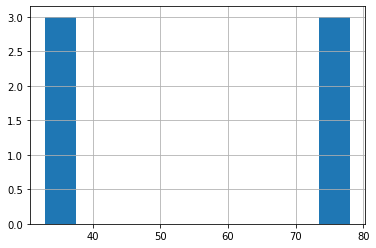

In [ ]:
df[df.partial_ratio<100].partial_ratio.hist()

In [ ]:
df #most likely wrong answers

,context,question,text,prediction_text,partial_ratio
10,"ปีที่ 2 ภาคการศึกษาที่ 1 ประกอบไปด้วย 8 รายวิชา ดังนี้ 01016110 คณิตศาสตร์วิศวกรรมไฟฟ้า (electrical engineering mathematics) 3 (3-0-6) หน่วยกิต,01016111 ความน่าจะเป็นและสถิติสำหรับวิศวกรรม (probability and statistics for engineers) 3 (3-0-6) หน่วยกิต,01016258 สัญญาณและระบบ (signals and systems) 3 (3-0-6) หน่วยกิต,01016250 การวิเคราะห์วงจรไฟฟ้า (electric circuit analysis) 3 (3-0-6) หน่วยกิต,01016251 ปฏิบัติการวงจรไฟฟ้า (electric circuit laboratory) 1 (0-3-1) หน่วยกิต,01016254 การออกแบบวงจรดิจิทัลและลอจิก (digital circuit and logic design) 3 (3-0-6) หน่วยกิต,01016255 ปฏิบัติการวงจรดิจิทัลและลอจิก (digital circuit and logic laboratory) 1 (0-3-1) หน่วยกิต,90595003 ภาษาอังกฤษเชิงวิชาการ (english for academic purposes) 3 (3-0-6) หน่วยกิต, รวม 20 หน่วยกิต",แผนการศึกษาปีที่ 2 ภาคการศึกษาที่ 1 เรียนจำนวนทั้งหมดกี่หน่วยกิต,20 หน่วยกิต,8 รายวิชา,33
9,"ปีที่ 2 ภาคการศึกษาที่ 1 ประกอบไปด้วย 8 รายวิชา ดังนี้ 01016110 คณิตศาสตร์วิศวกรรมไฟฟ้า (electrical engineering mathematics) 3 (3-0-6) หน่วยกิต,01016111 ความน่าจะเป็นและสถิติสำหรับวิศวกรรม (probability and statistics for engineers) 3 (3-0-6) หน่วยกิต,01016258 สัญญาณและระบบ (signals and systems) 3 (3-0-6) หน่วยกิต,01016250 การวิเคราะห์วงจรไฟฟ้า (electric circuit analysis) 3 (3-0-6) หน่วยกิต,01016251 ปฏิบัติการวงจรไฟฟ้า (electric circuit laboratory) 1 (0-3-1) หน่วยกิต,01016254 การออกแบบวงจรดิจิทัลและลอจิก (digital circuit and logic design) 3 (3-0-6) หน่วยกิต,01016255 ปฏิบัติการวงจรดิจิทัลและลอจิก (digital circuit and logic laboratory) 1 (0-3-1) หน่วยกิต,90595003 ภาษาอังกฤษเชิงวิชาการ (english for academic purposes) 3 (3-0-6) หน่วยกิต, รวม 20 หน่วยกิต",แผนการศึกษาปีที่ 2 ภาคการศึกษาที่ 1 เรียนวิชาอะไรบ้าง,"01016110 คณิตศาสตร์วิศวกรรมไฟฟ้า (electrical engineering mathematics) 3 (3-0-6) หน่วยกิต,01016111 ความน่าจะเป็นและสถิติสำหรับวิศวกรรม (probability and statistics for engineers) 3 (3-0-6) หน่วยกิต,01016258 สัญญาณและระบบ (signals and systems) 3 (3-0-6) หน่วยกิต,01016250 การวิเคราะห์วงจรไฟฟ้า (electric circuit analysis) 3 (3-0-6) หน่วยกิต,01016251 ปฏิบัติการวงจรไฟฟ้า (electric circuit laboratory) 1 (0-3-1) หน่วยกิต,01016254 การออกแบบวงจรดิจิทัลและลอจิก (digital circuit and logic design) 3 (3-0-6) หน่วยกิต,01016255 ปฏิบัติการวงจรดิจิทัลและลอจิก (digital circuit and logic laboratory) 1 (0-3-1) หน่วยกิต,90595003 ภาษาอังกฤษเชิงวิชาการ (english for academic purposes) 3 (3-0-6) หน่วยกิต",8 รายวิชา,33
20,"ปีที่ 2 ภาคการศึกษาที่ 2 ประกอบไปด้วย 8 รายวิชา ดังนี้ 01016252 สนามและคลื่นแม่เหล็กไฟฟ้า (electromagnetic fields and waves) 3 (3-0-6) หน่วยกิต,01016256 อิเล็กทรอนิกส์วิศวกรรม (engineering electronics) 3 (3-0-6) หน่วยกิต,01016257 ปฏิบัติการอิเล็กทรอนิกส์ (electronics laboratory) 1 (0-3-1) หน่วยกิต,01016260 ระบบสมองกลฝังตัวและการประยุกต์ใช้งาน (embedded systems and applications) 3 (3-0-6) หน่วยกิต,01016261 ปฏิบัติการระบบสมองกลฝังตัว (embedded systems laboratory) 1 (0-3-1) หน่วยกิต,01016350 ระบบควบคุม (control systems) 3 (3-0-6) หน่วยกิต,01016262 หลักการสื่อสาร (principles of communications) 3 (3-0-6) หน่วยกิต,90xxxxxx กลุ่มวิชาศึกษาทั่วไป (general education) 3 (3-0-6) หน่วยกิต,รวม 20 หน่วยกิต",แผนการศึกษาปีที่ 2 ภาคการศึกษาที่ 2 เรียนวิชาอะไรบ้าง,"01016252 สนามและคลื่นแม่เหล็กไฟฟ้า (electromagnetic fields and waves) 3 (3-0-6) หน่วยกิต,01016256 อิเล็กทรอนิกส์วิศวกรรม (engineering electronics) 3 (3-0-6) หน่วยกิต,01016257 ปฏิบัติการอิเล็กทรอนิกส์ (electronics laboratory) 1 (0-3-1) หน่วยกิต,01016260 ระบบสมองกลฝังตัวและการประยุกต์ใช้งาน (embedded systems and applications) 3 (3-0-6) หน่วยกิต,01016261 ปฏิบัติการระบบสมองกลฝังตัว (embedded systems laboratory) 1 (0-3-1) หน่วยกิต,01016350 ระบบควบคุม (control systems) 3 (3-0-6) หน่วยกิต,01016262 หลักการสื่อสาร (principles of communications) 3 (3-0-6) หน่วยกิต,90xxxxxx กลุ่มวิชาศึกษาทั่วไป (general education) 3 (3-0-6) หน่วยกิต",8 รายวิชา,33
3,"แผนการศึกษาปีที่ 1 ภาคการศึกษาที่ 2 ประกอบไปด้วย 8 รายวิชา ดังนี้ 01006031 แคลคูลัส 2 (calculus 2) 3 (3-0-6) หน่วยกิต,01006022 ฟิสิกส์ทั่วไป 2 (general physics 2) 3 (